# JAX-GCM (JCM) Demo 

<img src="../logo.png" alt="JAX-GCM Logo" width="200"/>

This notebook demonstrates the capabilities of JAX-GCM (JCM), a differentiable general circulation model built using JAX. 

We will showcase how to set up a simple atmospheric simulation, run the model, and visualize the results. Additionally, we will illustrate how to compute gradients with respect to model parameters using JAX's automatic differentiation features.



In [ ]:
from jcm.model import Model
from jcm.geometry import Geometry
from jcm.forcing import ForcingData

# Load the terrain and forcing data
realistic_geometry = Geometry.from_terrain_file('../jcm/data/bc/t30/clim/terrain.nc', interpolate=True, target_resolution=31)
realistic_forcing = ForcingData.from_file('../jcm/data/bc/t30/clim/forcing.nc', interpolate=True, target_resolution=31)

In [8]:
model = Model(
    geometry=realistic_geometry,
)

predictions = model.run(
    save_interval=5,
    total_time=30,
    output_averages=True,
    forcing=realistic_forcing,
)

pred_ds = model.predictions_to_xarray(predictions)
pred_ds

<xarray.Dataset> Size: 22MB
Dimensions:                          (time: 6, lon: 96, lat: 48, level: 8)
Coordinates:
  * lon                              (lon) float64 768B 0.0 3.75 ... 352.5 356.2
  * lat                              (lat) float64 384B -87.16 -83.48 ... 87.16
  * level                            (level) float32 32B 0.95 0.835 ... 0.025
  * time                             (time) datetime64[ns] 48B 2000-01-01 ......
Data variables: (12/79)
    convection.cbmf                  (time, lon, lat) float32 111kB 0.0 ... 0.0
    surface_flux.ustr.0              (time, lon, lat) float32 111kB 0.3852 .....
    mod_radcon.flux.2                (time, lon, lat) float32 111kB 117.7 ......
    surface_flux.u0                  (time, lon, lat) float32 111kB -9.234 .....
    shortwave_rad.ozupp              (time, lon, lat) float32 111kB 7.265 ......
    mod_radcon.st4a.0                (time, level, lon, lat) float32 885kB 35...
    ...                               ...
    surface_flux.rlus.0              (time, lon, lat) float32 111kB 349.0 ......
    shortwave_rad.fsol               (time, lon, lat) float32 111kB 551.1 ......
    date.dt_seconds                  (time) float32 24B 1.8e+03 ... 1.8e+03
    humidity.rh                      (time, level, lon, lat) float32 885kB 0....
    surface_flux.ustr.1              (time, lon, lat) float32 111kB 0.05304 ....
    surface_flux.shf.2               (time, lon, lat) float32 111kB 22.72 ......
Attributes:
    longitude_wavenumbers:     32
    total_wavenumbers:         33
    longitude_nodes:           96
    latitude_nodes:            48
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    6371220.0
    spherical_harmonics_impl:  RealSphericalHarmonics
    spmd_mesh:                 
    boundaries:                [0.0, 0.05000000074505806, 0.14000000059604645...
    horizontal_grid_type:      Grid
    vertical_grid_type:        SigmaCoordinates

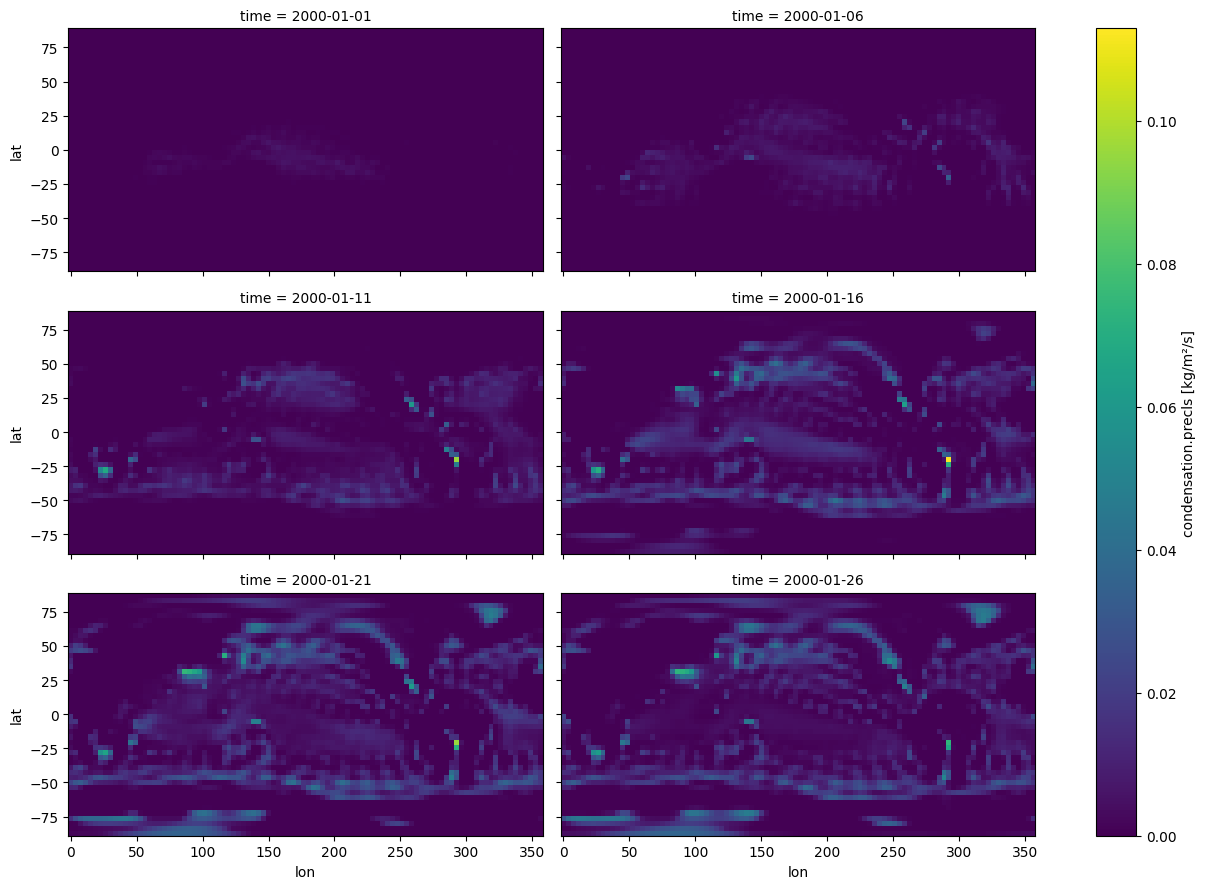

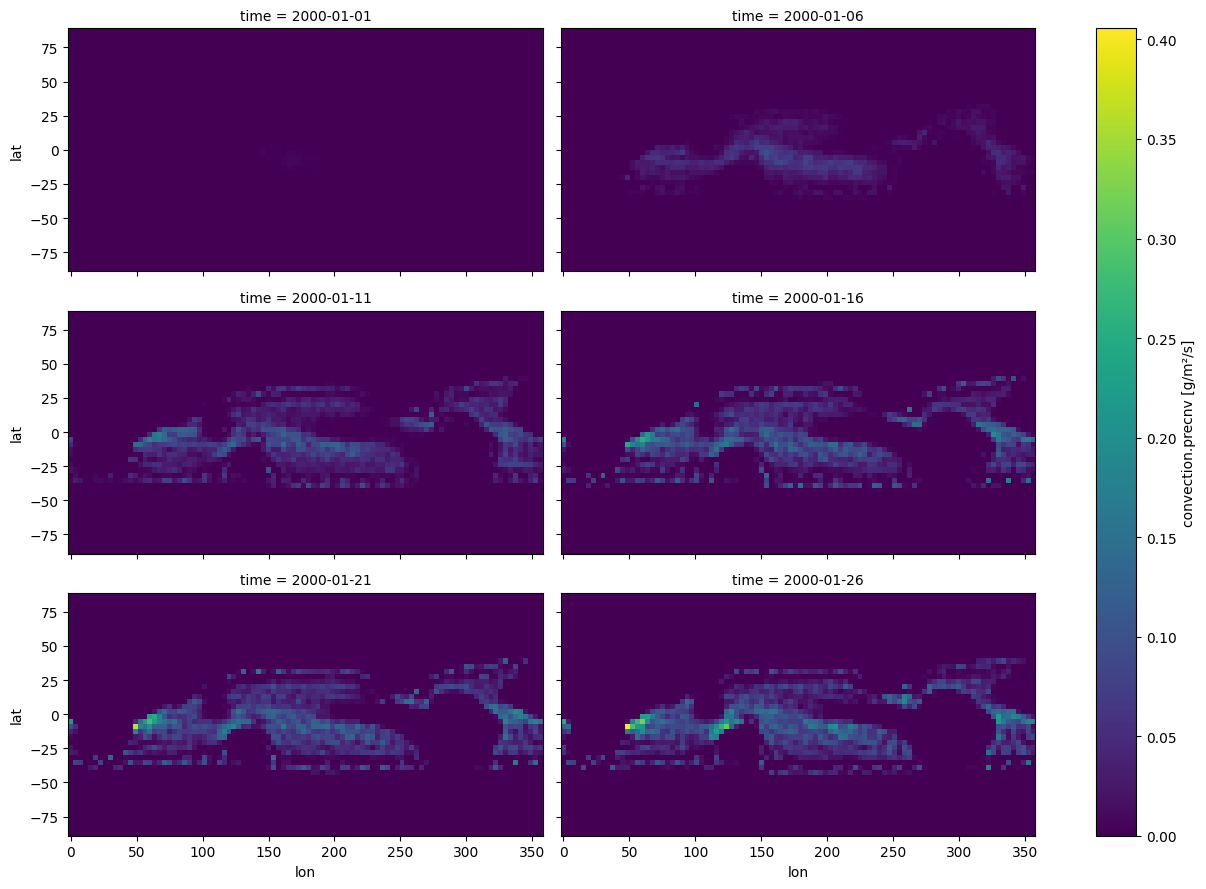

In [9]:
pred_ds['condensation.precls'].plot(x='lon', y='lat', col='time', col_wrap=2, aspect=2)
pred_ds['convection.precnv'].plot(x='lon', y='lat', col='time', col_wrap=2, aspect=2)

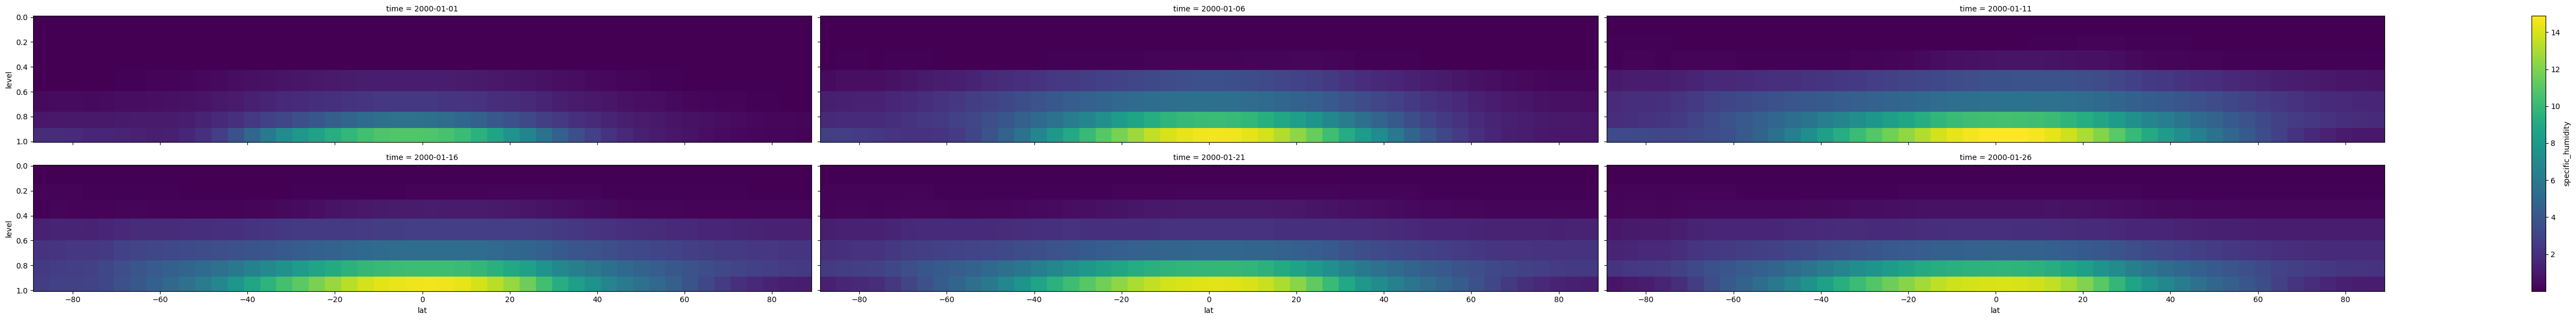

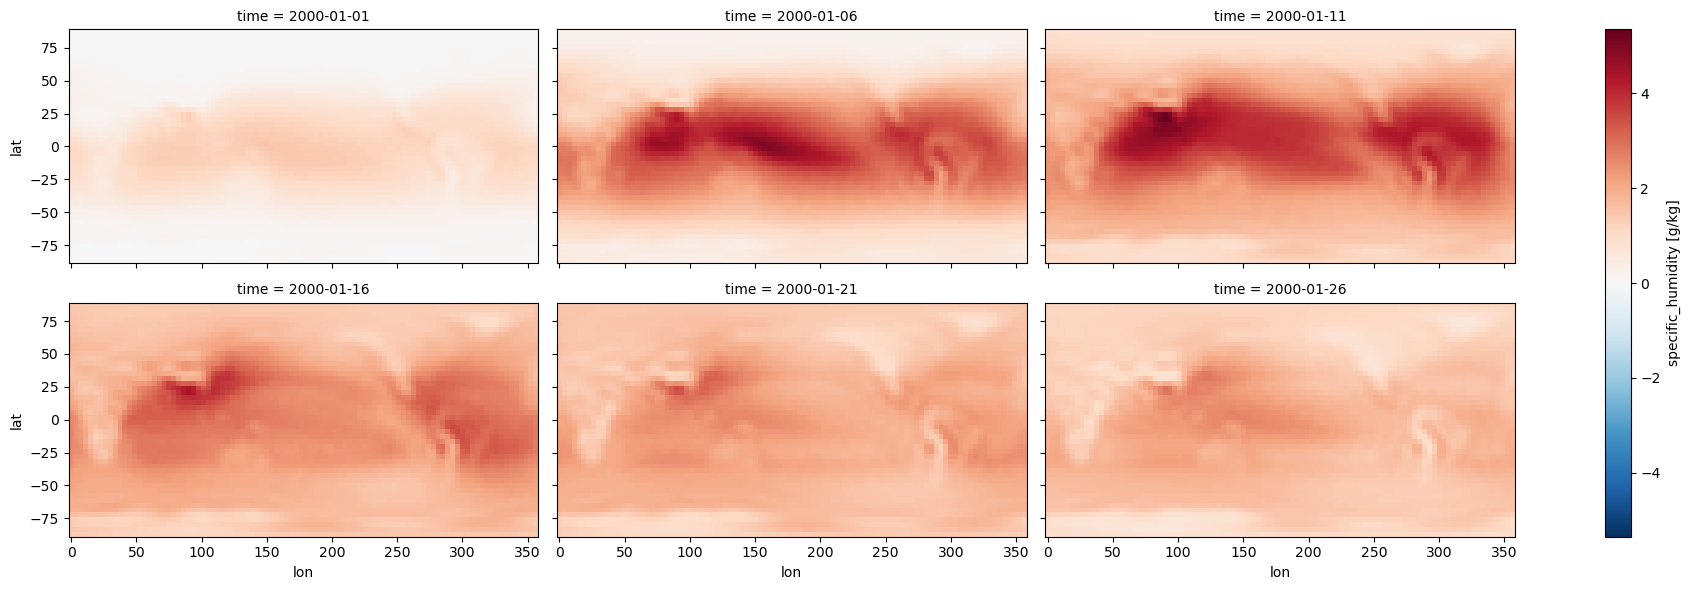

In [4]:
pred_ds['specific_humidity'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False)
pred_ds['specific_humidity'].isel(level=3).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

### Clouds!

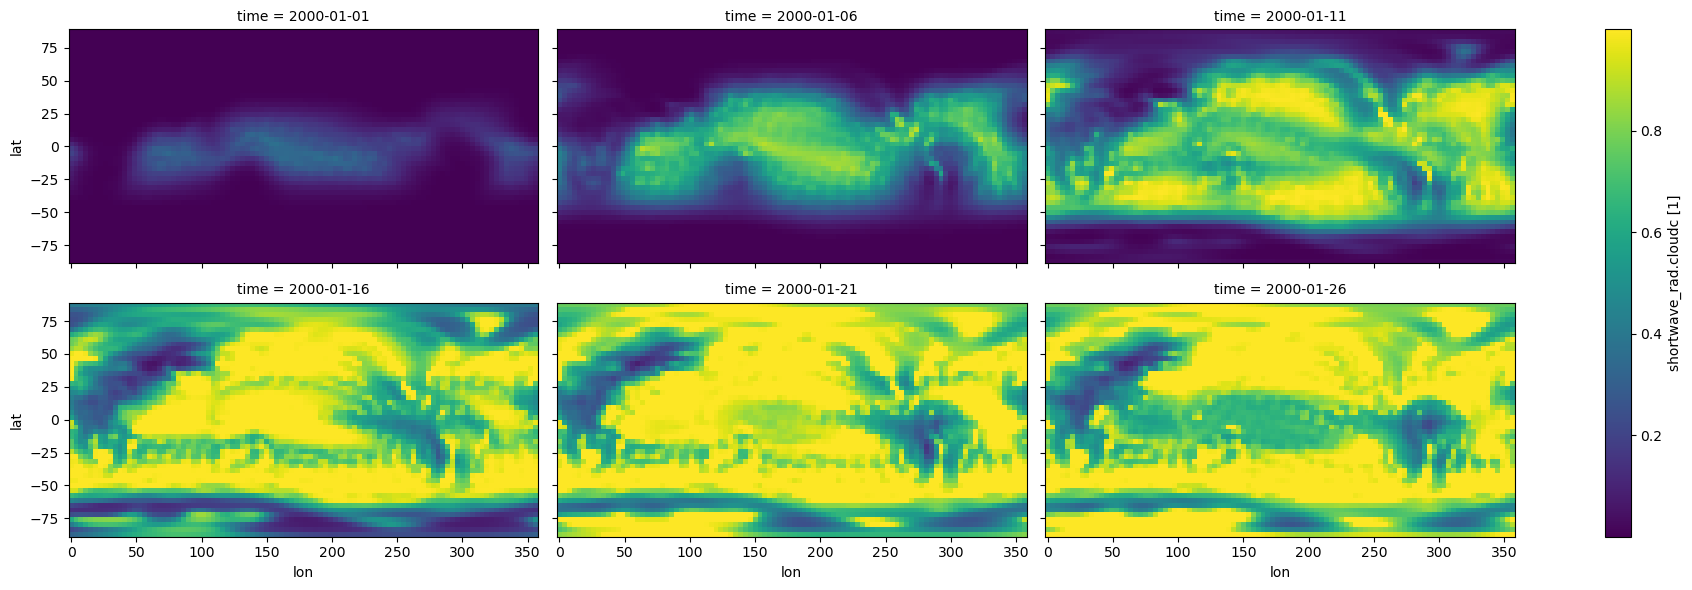

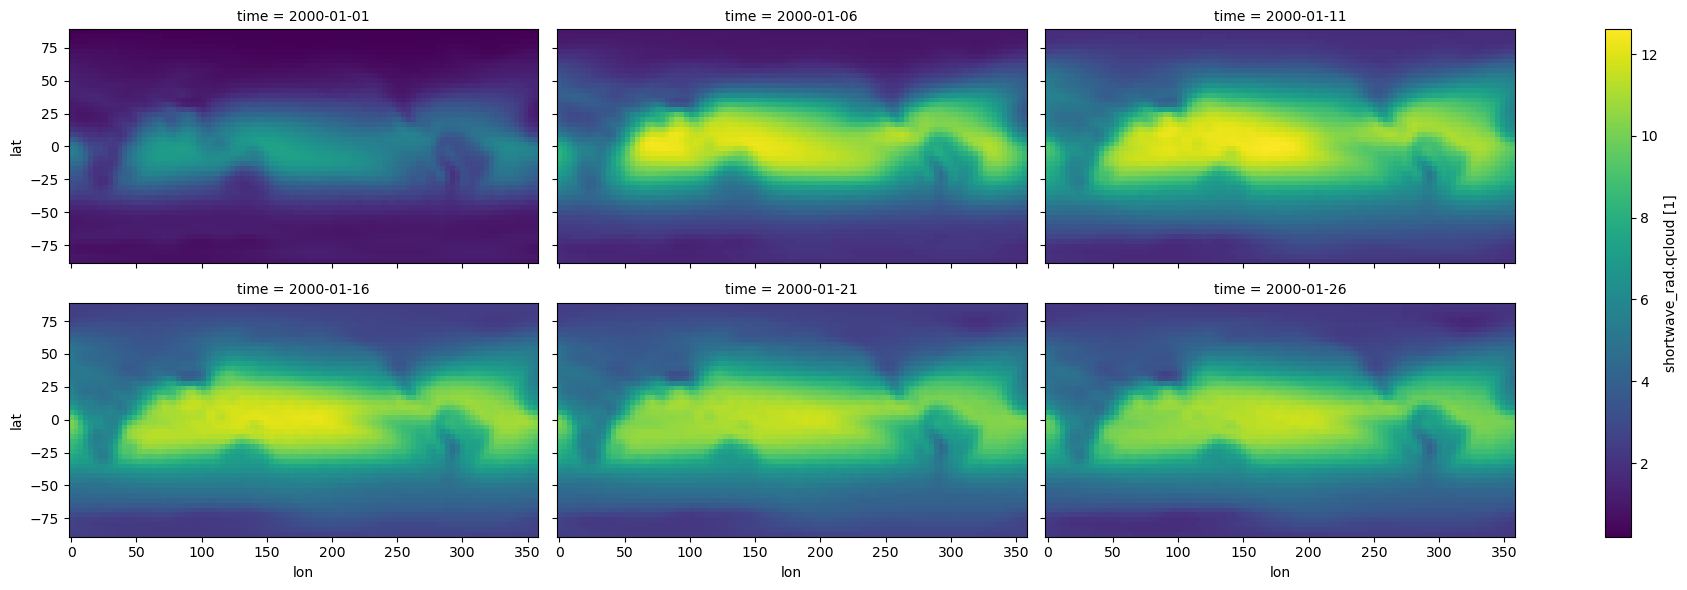

In [5]:
pred_ds['shortwave_rad.cloudc'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)
pred_ds['shortwave_rad.qcloud'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2)

## Continue running

Continue a simulation from the previous state for an additional 30 days, saving every 5 days and outputting averages.


In [ ]:
predictions = model.resume(
    total_time=30,
    output_averages=True,
    forcing=realistic_forcing,
)

Sometimes, for example in a coupled run we want a pure JAX interface to enable compilation of a larger model. We can do this using the `run_from_state` method:

```python
model.run_from_state(
    initial_state=model._final_modal_state,
    total_time=30,
    output_averages=True,
    forcing=realistic_forcing,
)
```

## Note on speed and efficiency

Some preliminary tests show very good performance on a variety of devices but especially on GPUs and TPUs. For example, on a V100 GPU we see around 10x speedup compared to a CPU run. JCM also supports parallelization across multiple devices using JAX's `pmap` functionality, which can further enhance performance for large-scale simulations.

<center><img src="jcm_scaling.png" alt="JCM Performance" width="400"/></center>

## Model Gradients

We can compute gradients of model outputs with respect to model parameters using JAX's automatic differentiation. 

In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jcm.physics.speedy.speedy_physics import SpeedyPhysics
from jcm.physics.speedy.params import Parameters

# Key step - create a function that makes a model given parameters
def model_run_wrapper(params):
    model = Model(geometry=realistic_geometry, physics=SpeedyPhysics(parameters=params))

    return model.run(save_interval=1, total_time=1, forcing=realistic_forcing, output_averages=True)

In [8]:
# VJP is the vector-Jacobian product and calculates the gradient of outputs with respect to inputs

primal, vjp_fn = jax.vjp(model_run_wrapper, Parameters.default())

In [9]:
def create_cotangent(primal):
    cotangent = jtu.tree_map(jnp.zeros_like, primal)
    cotangent.physics.shortwave_rad.ftop = jtu.tree_map(jnp.ones_like, cotangent.physics.shortwave_rad.ftop)
    return cotangent

grad, = vjp_fn(create_cotangent(primal))

In [12]:
print(grad)

Parameters(convection=ConvectionParameters(psmin=0.0,
                                           trcnv=0.0,
                                           rhil=0.0,
                                           rhbl=0.0,
                                           entmax=0.0,
                                           smf=0.0),
           condensation=CondensationParameters(trlsc=0.0,
                                               rhlsc=0.0,
                                               drhlsc=0.0,
                                               rhblsc=0.0),
           shortwave_radiation=ShortwaveRadiationParameters(albcl=-0.034563131630420685,
                                                            albcls=-502230.5625,
                                                            absdry=1004539.0625,
                                                            absaer=297534.34375,
                                                            abswv1=159370.4375,
                               

We can also calculate the Jacobian-vector product (JVP) to get gradients of specific outputs with respect to a parameter

In [ ]:
# Define a tangent vector for JVP
params = Parameters.default()
tangent = Parameters.zeros()
tangent.mod_radcon.albsea = jnp.array(1.)

y, jvp_at_x = jax.jvp(model_run_wrapper, (params,), (tangent,))

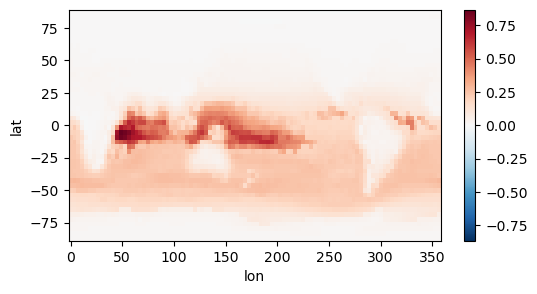

In [ ]:
import xarray as xr
xr.DataArray(jvp_at_x.physics.surface_flux.hfluxn[0, :, :, 0], dims=['lon', 'lat'],
                coords={'lat': pred_ds.lat, 'lon': pred_ds.lon}).plot(x='lon', y='lat', size=3, aspect=2)

## Advanced

Sometimes it can be useful to control the compilation or execution of the JAX code more directly. JAX has configuration functions to facilitate this.

In [ ]:
print("JAX device:", jax.devices())

# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"  # for use on ARM Macs

jax.config.update('jax_disable_jit', False) # disable if necessary for debugging
jax.config.update("jax_debug_infs", True) # watch for model blowup
jax.config.update("jax_debug_nans", False) # some physics fields might be nan